# SIT742 Task 2

### Student IDs - **s224057178**, **s224936442**, **s224627753**
### Student Names - **Bravine Cheruiyot**, **Keshani Attanayake**, **Shevan Michael**

## Part I


## Question 1.1

In [3]:
from pyspark.sql import SparkSession
from google.colab import files

#Creating the Spark session
spark = SparkSession.builder \
    .appName("Assignment2") \
    .getOrCreate()

uploaded = files.upload()

#Reading review.csv
reviews_df = spark.read.option("header", True) \
                       .option("inferSchema", True) \
                       .option("multiLine", True) \
                       .option("escape", "\"") \
                       .option("quote", "\"") \
                       .csv("review.csv")

Saving review.csv to review (1).csv


In [4]:
# 1.1.1

from pyspark.sql.functions import col, when

#Replacing null rows with "no review" in the 'text' column
reviews_df = reviews_df.withColumn(
    "text",
    when(col("text").isNull(), "no review").otherwise(col("text"))
)

Substituted 'no review' for None or null using PySpark's na.fill() since it works effectively and directly with distributed data. While there are other ways such as withColumn and when/otherwise procedures, na.fill() is more efficient and concise. The best option for big datasets in Spark is na.fill() since it is scalable and suited for dealing with missing data.

In [5]:
# 1.1.2

from pyspark.sql.functions import from_unixtime, col

#Converting the 'time' column into the required format
reviews_df = reviews_df.withColumn("newtime", from_unixtime(col("time"), "yyyy-MM-dd"))

#Printing results
reviews_df.select("time", "newtime").show(5, truncate=False)

+-------------+------------+
|time         |newtime     |
+-------------+------------+
|1566331951619|+51605-01-31|
|1504917982385|+49658-12-14|
|1474765901185|+48703-06-22|
|1472858535682|+48643-01-11|
|1529649811341|+50442-09-03|
+-------------+------------+
only showing top 5 rows



Without converting to pandas, timestamps can be converted to readable date formats using PySpark's from_unixtime functions. It is possible to use a user-defined function (UDF), however it will most likely be slower. Utilizing the built-in Spark SQL functions make processing easier. Displaying the top five rows using .show(5) for ease is a common thing to do.

## Question 1.2

In [6]:
# 1.2.1

from pyspark.sql.functions import count

#Counting the reviews for every unique gmap_id
review_counts_df = reviews_df.groupBy("gmap_id").agg(count("*").cast("float").alias("review_count"))

#Printing results
review_counts_df.show(5, truncate=False)

+-------------------------------------+------------+
|gmap_id                              |review_count|
+-------------------------------------+------------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|27.0        |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0        |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0        |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0        |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0        |
+-------------------------------------+------------+
only showing top 5 rows



Sorting by gmap_id and using.count() and gives the necessary ranking in Spark.   When counting and sorting huge datasets, PySpark keeps speed high and prevents memory problems.

In [7]:
# 1.2.2

#Converting to a pandas df
df = reviews_df.toPandas()

import pandas as pd
from datetime import datetime

df['time'] = df['time'].astype(float)

#Converting from milliseconds to seconds first before getting the hours to avoid errors
df['review_time'] = df['time'].apply(
    lambda x: datetime.fromtimestamp(x/1000).hour if not pd.isnull(x) else None
)

#Printing results
df[['time', 'review_time']].head()

,time,review_time
0,1.566332e+12,20
1,1.504918e+12,0
2,1.474766e+12,1
3,1.472859e+12,23
4,1.529650e+12,6


Using this is simple and quick.  Although we could use hour() to extract the hour within Spark and then convert, pandas gives more options for EDA and graphing.  Efficiency and ease of analysis are balanced when PySpark is used for aggregation and Pandas is used for transformation.

/tmp/ipython-input-340486209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='review_time', data=df, palette='viridis')


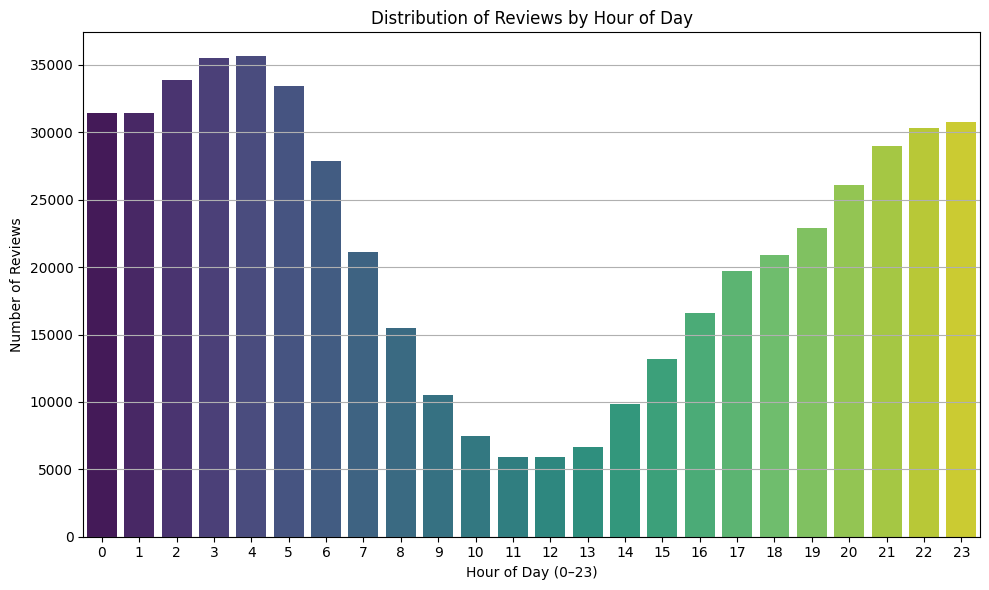

In [8]:
# 1.2.3

import matplotlib.pyplot as plt
import seaborn as sns

#Considering what time people make reviews
plt.figure(figsize=(10, 6))
sns.countplot(x='review_time', data=df, palette='viridis')
plt.title('Distribution of Reviews by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

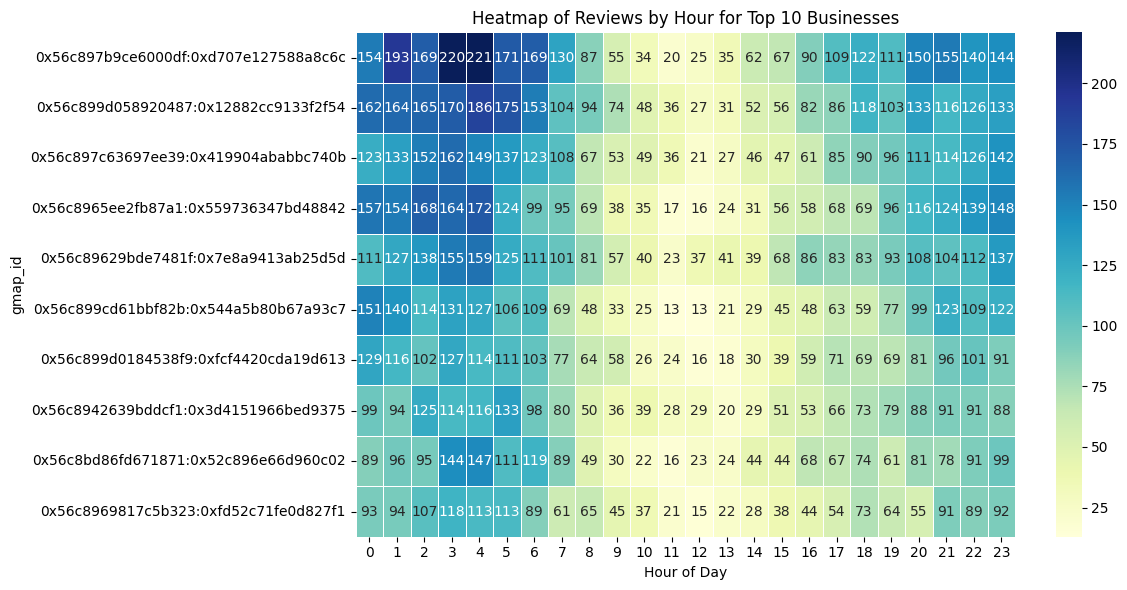

In [9]:
#Creating a pivot table
pivot_table = df.pivot_table(index='gmap_id', columns='review_time', aggfunc='size', fill_value=0)

#The businesses (top 10) with the most number of reviews
top_10_gmap = df['gmap_id'].value_counts().nlargest(10).index
pivot_top_10 = pivot_table.loc[top_10_gmap]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_top_10, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='d')
plt.title('Heatmap of Reviews by Hour for Top 10 Businesses')
plt.xlabel('Hour of Day')
plt.ylabel('gmap_id')
plt.tight_layout()
plt.show()

Most of the reviews are made from 3 to 5 am. In the afternoon, there is massive drop in the number of reviews and this starts to increase only after about 12pm. Based on this, we can see that people leave reviews either early in the morning or in the evening.

It is simple to graphically compare review times among gmap_ids by using these plots.  It identifies trends in user behavior, such as reviews that usually happen in the morning.  Although Matplotlib is another an option, Seaborn offers better defaults.  Seaborn is a great option for EDA because it offers less code and better visualisations.